In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

# Fetch Dataset 

In [15]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
N_ELECTRONS = 30
basis = "sto-3g"
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(index))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)

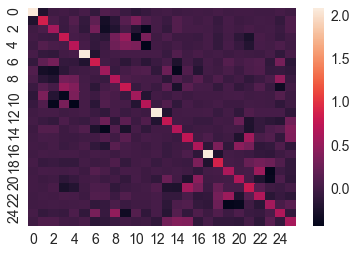

In [7]:
import seaborn as sns

sns.heatmap(P[0].reshape(dim, dim))

# Utilities 

In [11]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [12]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    p_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 21:52:31: Iteration calculation: 0
[ ] 2018-10-11 21:52:31: Iteration calculation: 1
[ ] 2018-10-11 21:52:31: Iteration calculation: 2
[ ] 2018-10-11 21:52:31: Iteration calculation: 3
[ ] 2018-10-11 21:52:31: Iteration calculation: 4
[ ] 2018-10-11 21:52:31: Iteration calculation: 5
[ ] 2018-10-11 21:52:31: Iteration calculation: 6
[ ] 2018-10-11 21:52:31: Iteration calculation: 7
[ ] 2018-10-11 21:52:31: Iteration calculation: 8
[ ] 2018-10-11 21:52:32: Iteration calculation: 9
[ ] 2018-10-11 21:52:32: Iteration calculation: 10
[ ] 2018-10-11 21:52:32: Iteration calculation: 11
[ ] 2018-10-11 21:52:32: Iteration calculation: 12
[ ] 2018-10-11 21:52:32: Iteration calculation: 13
[ ] 2018-10-11 21:52:32: Iteration calculation: 14
[ ] 2018-10-11 21:52:32: Iteration calculation: 15
[ ] 2018-10-11 21:52:32: Iteration calculation: 16
[ ] 2018-10-11 21:52:32: Iteration calculation: 17
[ ] 2018-10-11 21:52:32: Iteration calculation: 18
[ ] 2018-10-11 21:52:32: Iteration calcul

[ ] 2018-10-11 21:52:47: Iteration calculation: 161
[ ] 2018-10-11 21:52:47: Iteration calculation: 162
[ ] 2018-10-11 21:52:47: Iteration calculation: 163
[ ] 2018-10-11 21:52:47: Iteration calculation: 164
[ ] 2018-10-11 21:52:47: Iteration calculation: 165
[ ] 2018-10-11 21:52:48: Iteration calculation: 166
[ ] 2018-10-11 21:52:48: Iteration calculation: 167
[ ] 2018-10-11 21:52:48: Iteration calculation: 168
[ ] 2018-10-11 21:52:48: Iteration calculation: 169
[ ] 2018-10-11 21:52:48: Iteration calculation: 170
[ ] 2018-10-11 21:52:48: Iteration calculation: 171
[ ] 2018-10-11 21:52:48: Iteration calculation: 172
[ ] 2018-10-11 21:52:48: Iteration calculation: 173
[ ] 2018-10-11 21:52:48: Iteration calculation: 174
[ ] 2018-10-11 21:52:48: Iteration calculation: 175
[ ] 2018-10-11 21:52:49: Iteration calculation: 176
[ ] 2018-10-11 21:52:49: Iteration calculation: 177
[ ] 2018-10-11 21:52:49: Iteration calculation: 178
[ ] 2018-10-11 21:52:49: Iteration calculation: 179
[ ] 2018-10-

# Pure blocks

i will now set all other elements zero

## Utilities

In [13]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[0][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

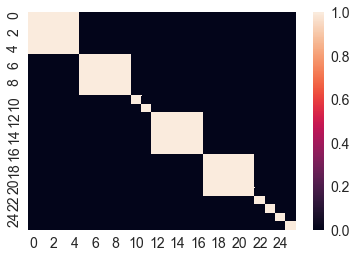

In [9]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [16]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = p.copy()
    p_batch[np.logical_not(mask)] = 0
    return p_batch

p_pure = np.array(list(map(extract_pure, p_test))).astype("float64")

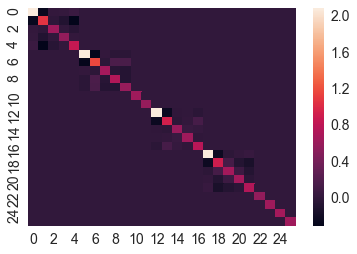

In [18]:
sns.heatmap(p_pure[0])

In [19]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    p_pure,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 21:56:14: Iteration calculation: 0
[ ] 2018-10-11 21:56:16: Iteration calculation: 1
[ ] 2018-10-11 21:56:16: Iteration calculation: 2
[ ] 2018-10-11 21:56:17: Iteration calculation: 3
[ ] 2018-10-11 21:56:17: Iteration calculation: 4
[ ] 2018-10-11 21:56:18: Iteration calculation: 5
[ ] 2018-10-11 21:56:19: Iteration calculation: 6
[ ] 2018-10-11 21:56:19: Iteration calculation: 7
[ ] 2018-10-11 21:56:19: Iteration calculation: 8
[ ] 2018-10-11 21:56:20: Iteration calculation: 9
[ ] 2018-10-11 21:56:20: Iteration calculation: 10
[ ] 2018-10-11 21:56:21: Iteration calculation: 11
[ ] 2018-10-11 21:56:21: Iteration calculation: 12
[ ] 2018-10-11 21:56:22: Iteration calculation: 13
[ ] 2018-10-11 21:56:23: Iteration calculation: 14
[ ] 2018-10-11 21:56:23: Iteration calculation: 15
[ ] 2018-10-11 21:56:24: Iteration calculation: 16
[ ] 2018-10-11 21:56:24: Iteration calculation: 17
[ ] 2018-10-11 21:56:25: Iteration calculation: 18
[ ] 2018-10-11 21:56:25: Iteration calcul

[ ] 2018-10-11 21:57:18: Iteration calculation: 160
[ ] 2018-10-11 21:57:18: Iteration calculation: 161
[ ] 2018-10-11 21:57:18: Iteration calculation: 162
[ ] 2018-10-11 21:57:19: Iteration calculation: 163
[ ] 2018-10-11 21:57:19: Iteration calculation: 164
[ ] 2018-10-11 21:57:19: Iteration calculation: 165
[ ] 2018-10-11 21:57:19: Iteration calculation: 166
[ ] 2018-10-11 21:57:19: Iteration calculation: 167
[ ] 2018-10-11 21:57:20: Iteration calculation: 168
[ ] 2018-10-11 21:57:20: Iteration calculation: 169
[ ] 2018-10-11 21:57:20: Iteration calculation: 170
[ ] 2018-10-11 21:57:20: Iteration calculation: 171
[ ] 2018-10-11 21:57:21: Iteration calculation: 172
[ ] 2018-10-11 21:57:21: Iteration calculation: 173
[ ] 2018-10-11 21:57:21: Iteration calculation: 174
[ ] 2018-10-11 21:57:22: Iteration calculation: 175
[ ] 2018-10-11 21:57:22: Iteration calculation: 176
[ ] 2018-10-11 21:57:22: Iteration calculation: 177
[ ] 2018-10-11 21:57:23: Iteration calculation: 178
[ ] 2018-10-

# Embedding the Blocks In Classical Guesses

In [20]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


## Convergedn in Converged 

In [21]:
p_test_test = embedd_batch(p_test)

In [22]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    p_test_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 21:59:52: Iteration calculation: 0
[ ] 2018-10-11 21:59:52: Iteration calculation: 1
[ ] 2018-10-11 21:59:52: Iteration calculation: 2
[ ] 2018-10-11 21:59:52: Iteration calculation: 3
[ ] 2018-10-11 21:59:52: Iteration calculation: 4
[ ] 2018-10-11 21:59:52: Iteration calculation: 5
[ ] 2018-10-11 21:59:52: Iteration calculation: 6
[ ] 2018-10-11 21:59:52: Iteration calculation: 7
[ ] 2018-10-11 21:59:53: Iteration calculation: 8
[ ] 2018-10-11 21:59:53: Iteration calculation: 9
[ ] 2018-10-11 21:59:53: Iteration calculation: 10
[ ] 2018-10-11 21:59:53: Iteration calculation: 11
[ ] 2018-10-11 21:59:53: Iteration calculation: 12
[ ] 2018-10-11 21:59:53: Iteration calculation: 13
[ ] 2018-10-11 21:59:53: Iteration calculation: 14
[ ] 2018-10-11 21:59:53: Iteration calculation: 15
[ ] 2018-10-11 21:59:53: Iteration calculation: 16
[ ] 2018-10-11 21:59:54: Iteration calculation: 17
[ ] 2018-10-11 21:59:54: Iteration calculation: 18
[ ] 2018-10-11 21:59:54: Iteration calcul

[ ] 2018-10-11 22:00:09: Iteration calculation: 161
[ ] 2018-10-11 22:00:09: Iteration calculation: 162
[ ] 2018-10-11 22:00:09: Iteration calculation: 163
[ ] 2018-10-11 22:00:09: Iteration calculation: 164
[ ] 2018-10-11 22:00:10: Iteration calculation: 165
[ ] 2018-10-11 22:00:10: Iteration calculation: 166
[ ] 2018-10-11 22:00:10: Iteration calculation: 167
[ ] 2018-10-11 22:00:10: Iteration calculation: 168
[ ] 2018-10-11 22:00:10: Iteration calculation: 169
[ ] 2018-10-11 22:00:10: Iteration calculation: 170
[ ] 2018-10-11 22:00:10: Iteration calculation: 171
[ ] 2018-10-11 22:00:10: Iteration calculation: 172
[ ] 2018-10-11 22:00:10: Iteration calculation: 173
[ ] 2018-10-11 22:00:11: Iteration calculation: 174
[ ] 2018-10-11 22:00:11: Iteration calculation: 175
[ ] 2018-10-11 22:00:11: Iteration calculation: 176
[ ] 2018-10-11 22:00:11: Iteration calculation: 177
[ ] 2018-10-11 22:00:11: Iteration calculation: 178
[ ] 2018-10-11 22:00:11: Iteration calculation: 179
[ ] 2018-10-

## SAD 

In [24]:
from pyscf.scf import hf

p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

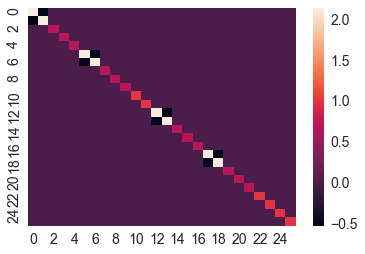

In [25]:
sns.heatmap(p_sad[0])

In [26]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 22:02:52: Iteration calculation: 0
[ ] 2018-10-11 22:02:53: Iteration calculation: 1
[ ] 2018-10-11 22:02:53: Iteration calculation: 2
[ ] 2018-10-11 22:02:54: Iteration calculation: 3
[ ] 2018-10-11 22:02:54: Iteration calculation: 4
[ ] 2018-10-11 22:02:54: Iteration calculation: 5
[ ] 2018-10-11 22:02:55: Iteration calculation: 6
[ ] 2018-10-11 22:02:55: Iteration calculation: 7
[ ] 2018-10-11 22:02:55: Iteration calculation: 8
[ ] 2018-10-11 22:02:55: Iteration calculation: 9
[ ] 2018-10-11 22:02:56: Iteration calculation: 10
[ ] 2018-10-11 22:02:56: Iteration calculation: 11
[ ] 2018-10-11 22:02:56: Iteration calculation: 12
[ ] 2018-10-11 22:02:56: Iteration calculation: 13
[ ] 2018-10-11 22:02:57: Iteration calculation: 14
[ ] 2018-10-11 22:02:57: Iteration calculation: 15
[ ] 2018-10-11 22:02:57: Iteration calculation: 16
[ ] 2018-10-11 22:02:58: Iteration calculation: 17
[ ] 2018-10-11 22:02:58: Iteration calculation: 18
[ ] 2018-10-11 22:02:58: Iteration calcul

[ ] 2018-10-11 22:03:39: Iteration calculation: 160
[ ] 2018-10-11 22:03:39: Iteration calculation: 161
[ ] 2018-10-11 22:03:40: Iteration calculation: 162
[ ] 2018-10-11 22:03:40: Iteration calculation: 163
[ ] 2018-10-11 22:03:40: Iteration calculation: 164
[ ] 2018-10-11 22:03:40: Iteration calculation: 165
[ ] 2018-10-11 22:03:41: Iteration calculation: 166
[ ] 2018-10-11 22:03:41: Iteration calculation: 167
[ ] 2018-10-11 22:03:41: Iteration calculation: 168
[ ] 2018-10-11 22:03:41: Iteration calculation: 169
[ ] 2018-10-11 22:03:42: Iteration calculation: 170
[ ] 2018-10-11 22:03:42: Iteration calculation: 171
[ ] 2018-10-11 22:03:42: Iteration calculation: 172
[ ] 2018-10-11 22:03:42: Iteration calculation: 173
[ ] 2018-10-11 22:03:43: Iteration calculation: 174
[ ] 2018-10-11 22:03:43: Iteration calculation: 175
[ ] 2018-10-11 22:03:43: Iteration calculation: 176
[ ] 2018-10-11 22:03:44: Iteration calculation: 177
[ ] 2018-10-11 22:03:44: Iteration calculation: 178
[ ] 2018-10-

## Embedded SAD

In [33]:
p_embedded_sad = embedd_batch(p_sad)

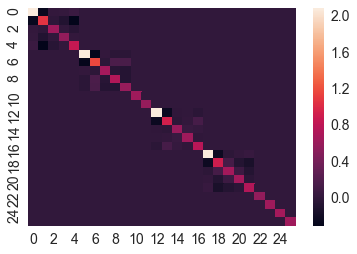

In [34]:
sns.heatmap(p_embedded_sad[0])

In [35]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 22:08:46: Iteration calculation: 0
[ ] 2018-10-11 22:08:47: Iteration calculation: 1
[ ] 2018-10-11 22:08:47: Iteration calculation: 2
[ ] 2018-10-11 22:08:48: Iteration calculation: 3
[ ] 2018-10-11 22:08:48: Iteration calculation: 4
[ ] 2018-10-11 22:08:49: Iteration calculation: 5
[ ] 2018-10-11 22:08:49: Iteration calculation: 6
[ ] 2018-10-11 22:08:50: Iteration calculation: 7
[ ] 2018-10-11 22:08:50: Iteration calculation: 8
[ ] 2018-10-11 22:08:50: Iteration calculation: 9
[ ] 2018-10-11 22:08:50: Iteration calculation: 10
[ ] 2018-10-11 22:08:51: Iteration calculation: 11
[ ] 2018-10-11 22:08:51: Iteration calculation: 12
[ ] 2018-10-11 22:08:52: Iteration calculation: 13
[ ] 2018-10-11 22:08:52: Iteration calculation: 14
[ ] 2018-10-11 22:08:53: Iteration calculation: 15
[ ] 2018-10-11 22:08:53: Iteration calculation: 16
[ ] 2018-10-11 22:08:53: Iteration calculation: 17
[ ] 2018-10-11 22:08:54: Iteration calculation: 18
[ ] 2018-10-11 22:08:54: Iteration calcul

[ ] 2018-10-11 22:09:57: Iteration calculation: 160
[ ] 2018-10-11 22:09:57: Iteration calculation: 161
[ ] 2018-10-11 22:09:58: Iteration calculation: 162
[ ] 2018-10-11 22:09:58: Iteration calculation: 163
[ ] 2018-10-11 22:09:58: Iteration calculation: 164
[ ] 2018-10-11 22:09:58: Iteration calculation: 165
[ ] 2018-10-11 22:09:59: Iteration calculation: 166
[ ] 2018-10-11 22:09:59: Iteration calculation: 167
[ ] 2018-10-11 22:09:59: Iteration calculation: 168
[ ] 2018-10-11 22:10:00: Iteration calculation: 169
[ ] 2018-10-11 22:10:00: Iteration calculation: 170
[ ] 2018-10-11 22:10:00: Iteration calculation: 171
[ ] 2018-10-11 22:10:00: Iteration calculation: 172
[ ] 2018-10-11 22:10:01: Iteration calculation: 173
[ ] 2018-10-11 22:10:01: Iteration calculation: 174
[ ] 2018-10-11 22:10:01: Iteration calculation: 175
[ ] 2018-10-11 22:10:02: Iteration calculation: 176
[ ] 2018-10-11 22:10:02: Iteration calculation: 177
[ ] 2018-10-11 22:10:03: Iteration calculation: 178
[ ] 2018-10-

## GWH

In [36]:
p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

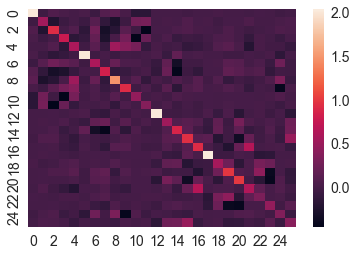

In [29]:
sns.heatmap(p_gwh[0])

In [30]:
print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 22:06:45: Iteration calculation: 0
[ ] 2018-10-11 22:06:46: Iteration calculation: 1
[ ] 2018-10-11 22:06:46: Iteration calculation: 2
[ ] 2018-10-11 22:06:47: Iteration calculation: 3
[ ] 2018-10-11 22:06:47: Iteration calculation: 4
[ ] 2018-10-11 22:06:47: Iteration calculation: 5
[ ] 2018-10-11 22:06:47: Iteration calculation: 6
[ ] 2018-10-11 22:06:48: Iteration calculation: 7
[ ] 2018-10-11 22:06:49: Iteration calculation: 8
[ ] 2018-10-11 22:06:49: Iteration calculation: 9
[ ] 2018-10-11 22:06:49: Iteration calculation: 10
[ ] 2018-10-11 22:06:50: Iteration calculation: 11
[ ] 2018-10-11 22:06:50: Iteration calculation: 12
[ ] 2018-10-11 22:06:51: Iteration calculation: 13
[ ] 2018-10-11 22:06:52: Iteration calculation: 14
[ ] 2018-10-11 22:06:53: Iteration calculation: 15
[ ] 2018-10-11 22:06:53: Iteration calculation: 16
[ ] 2018-10-11 22:06:54: Iteration calculation: 17
[ ] 2018-10-11 22:06:54: Iteration calculation: 18
[ ] 2018-10-11 22:06:54: Iteration calcul

[ ] 2018-10-11 22:07:38: Iteration calculation: 160
[ ] 2018-10-11 22:07:38: Iteration calculation: 161
[ ] 2018-10-11 22:07:39: Iteration calculation: 162
[ ] 2018-10-11 22:07:39: Iteration calculation: 163
[ ] 2018-10-11 22:07:39: Iteration calculation: 164
[ ] 2018-10-11 22:07:39: Iteration calculation: 165
[ ] 2018-10-11 22:07:40: Iteration calculation: 166
[ ] 2018-10-11 22:07:40: Iteration calculation: 167
[ ] 2018-10-11 22:07:40: Iteration calculation: 168
[ ] 2018-10-11 22:07:41: Iteration calculation: 169
[ ] 2018-10-11 22:07:41: Iteration calculation: 170
[ ] 2018-10-11 22:07:41: Iteration calculation: 171
[ ] 2018-10-11 22:07:42: Iteration calculation: 172
[ ] 2018-10-11 22:07:42: Iteration calculation: 173
[ ] 2018-10-11 22:07:42: Iteration calculation: 174
[ ] 2018-10-11 22:07:43: Iteration calculation: 175
[ ] 2018-10-11 22:07:43: Iteration calculation: 176
[ ] 2018-10-11 22:07:43: Iteration calculation: 177
[ ] 2018-10-11 22:07:44: Iteration calculation: 178
[ ] 2018-10-

## Embedded GWH 

In [37]:
p_embedded_gwh = embedd_batch(p_gwh)

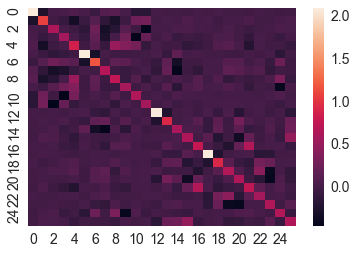

In [38]:
sns.heatmap(p_embedded_gwh[0])

In [39]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 22:12:21: Iteration calculation: 0
[ ] 2018-10-11 22:12:22: Iteration calculation: 1
[ ] 2018-10-11 22:12:22: Iteration calculation: 2
[ ] 2018-10-11 22:12:23: Iteration calculation: 3
[ ] 2018-10-11 22:12:23: Iteration calculation: 4
[ ] 2018-10-11 22:12:23: Iteration calculation: 5
[ ] 2018-10-11 22:12:23: Iteration calculation: 6
[ ] 2018-10-11 22:12:24: Iteration calculation: 7
[ ] 2018-10-11 22:12:24: Iteration calculation: 8
[ ] 2018-10-11 22:12:24: Iteration calculation: 9
[ ] 2018-10-11 22:12:24: Iteration calculation: 10
[ ] 2018-10-11 22:12:24: Iteration calculation: 11
[ ] 2018-10-11 22:12:25: Iteration calculation: 12
[ ] 2018-10-11 22:12:25: Iteration calculation: 13
[ ] 2018-10-11 22:12:25: Iteration calculation: 14
[ ] 2018-10-11 22:12:26: Iteration calculation: 15
[ ] 2018-10-11 22:12:26: Iteration calculation: 16
[ ] 2018-10-11 22:12:26: Iteration calculation: 17
[ ] 2018-10-11 22:12:26: Iteration calculation: 18
[ ] 2018-10-11 22:12:26: Iteration calcul

[ ] 2018-10-11 22:13:13: Iteration calculation: 160
[ ] 2018-10-11 22:13:13: Iteration calculation: 161
[ ] 2018-10-11 22:13:13: Iteration calculation: 162
[ ] 2018-10-11 22:13:14: Iteration calculation: 163
[ ] 2018-10-11 22:13:14: Iteration calculation: 164
[ ] 2018-10-11 22:13:14: Iteration calculation: 165
[ ] 2018-10-11 22:13:15: Iteration calculation: 166
[ ] 2018-10-11 22:13:15: Iteration calculation: 167
[ ] 2018-10-11 22:13:15: Iteration calculation: 168
[ ] 2018-10-11 22:13:16: Iteration calculation: 169
[ ] 2018-10-11 22:13:16: Iteration calculation: 170
[ ] 2018-10-11 22:13:16: Iteration calculation: 171
[ ] 2018-10-11 22:13:17: Iteration calculation: 172
[ ] 2018-10-11 22:13:17: Iteration calculation: 173
[ ] 2018-10-11 22:13:18: Iteration calculation: 174
[ ] 2018-10-11 22:13:18: Iteration calculation: 175
[ ] 2018-10-11 22:13:19: Iteration calculation: 176
[ ] 2018-10-11 22:13:19: Iteration calculation: 177
[ ] 2018-10-11 22:13:19: Iteration calculation: 178
[ ] 2018-10-

# McWheeny

In [40]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

def multi_mc_wheeny_batch(p_batch):
    p_res = []
    for p, s in zip(p_batch, s_test):
        p_res.append(multi_mc_wheeny(p, s, 5))
    return np.asarray(p_res)

## GWH 

In [41]:
p_embedded_gwh_mcw5 = multi_mc_wheeny_batch(p_embedded_gwh)

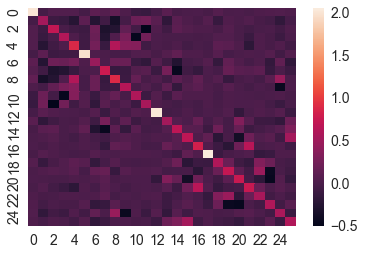

In [43]:
sns.heatmap(p_embedded_gwh_mcw5[0])

In [42]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 22:16:01: Iteration calculation: 0
[ ] 2018-10-11 22:16:01: Iteration calculation: 1
[ ] 2018-10-11 22:16:02: Iteration calculation: 2
[ ] 2018-10-11 22:16:02: Iteration calculation: 3
[ ] 2018-10-11 22:16:03: Iteration calculation: 4
[ ] 2018-10-11 22:16:03: Iteration calculation: 5
[ ] 2018-10-11 22:16:03: Iteration calculation: 6
[ ] 2018-10-11 22:16:04: Iteration calculation: 7
[ ] 2018-10-11 22:16:04: Iteration calculation: 8
[ ] 2018-10-11 22:16:04: Iteration calculation: 9
[ ] 2018-10-11 22:16:05: Iteration calculation: 10
[ ] 2018-10-11 22:16:05: Iteration calculation: 11
[ ] 2018-10-11 22:16:05: Iteration calculation: 12
[ ] 2018-10-11 22:16:06: Iteration calculation: 13
[ ] 2018-10-11 22:16:06: Iteration calculation: 14
[ ] 2018-10-11 22:16:07: Iteration calculation: 15
[ ] 2018-10-11 22:16:07: Iteration calculation: 16
[ ] 2018-10-11 22:16:07: Iteration calculation: 17
[ ] 2018-10-11 22:16:07: Iteration calculation: 18
[ ] 2018-10-11 22:16:08: Iteration calcul

[ ] 2018-10-11 22:16:53: Iteration calculation: 160
[ ] 2018-10-11 22:16:54: Iteration calculation: 161
[ ] 2018-10-11 22:16:54: Iteration calculation: 162
[ ] 2018-10-11 22:16:54: Iteration calculation: 163
[ ] 2018-10-11 22:16:54: Iteration calculation: 164
[ ] 2018-10-11 22:16:54: Iteration calculation: 165
[ ] 2018-10-11 22:16:55: Iteration calculation: 166
[ ] 2018-10-11 22:16:55: Iteration calculation: 167
[ ] 2018-10-11 22:16:55: Iteration calculation: 168
[ ] 2018-10-11 22:16:56: Iteration calculation: 169
[ ] 2018-10-11 22:16:56: Iteration calculation: 170
[ ] 2018-10-11 22:16:56: Iteration calculation: 171
[ ] 2018-10-11 22:16:56: Iteration calculation: 172
[ ] 2018-10-11 22:16:57: Iteration calculation: 173
[ ] 2018-10-11 22:16:57: Iteration calculation: 174
[ ] 2018-10-11 22:16:57: Iteration calculation: 175
[ ] 2018-10-11 22:16:58: Iteration calculation: 176
[ ] 2018-10-11 22:16:58: Iteration calculation: 177
[ ] 2018-10-11 22:16:58: Iteration calculation: 178
[ ] 2018-10-

## SAD 

In [44]:
p_embedded_sad_mcw5 = multi_mc_wheeny_batch(p_embedded_sad)

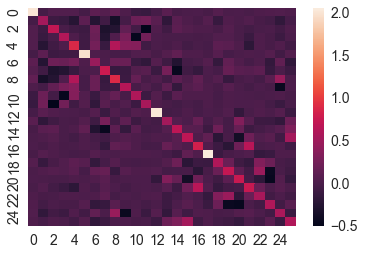

In [45]:
sns.heatmap(p_embedded_gwh_mcw5[0])

In [47]:
from SCFInitialGuess.utilities.analysis import mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_sad_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-10-11 22:22:14: Iteration calculation: 0
[ ] 2018-10-11 22:22:15: Iteration calculation: 1
[ ] 2018-10-11 22:22:15: Iteration calculation: 2
[ ] 2018-10-11 22:22:15: Iteration calculation: 3
[ ] 2018-10-11 22:22:16: Iteration calculation: 4
[ ] 2018-10-11 22:22:16: Iteration calculation: 5
[ ] 2018-10-11 22:22:17: Iteration calculation: 6
[ ] 2018-10-11 22:22:17: Iteration calculation: 7
[ ] 2018-10-11 22:22:17: Iteration calculation: 8
[ ] 2018-10-11 22:22:17: Iteration calculation: 9
[ ] 2018-10-11 22:22:18: Iteration calculation: 10
[ ] 2018-10-11 22:22:18: Iteration calculation: 11
[ ] 2018-10-11 22:22:19: Iteration calculation: 12
[ ] 2018-10-11 22:22:19: Iteration calculation: 13
[ ] 2018-10-11 22:22:20: Iteration calculation: 14
[ ] 2018-10-11 22:22:20: Iteration calculation: 15
[ ] 2018-10-11 22:22:20: Iteration calculation: 16
[ ] 2018-10-11 22:22:21: Iteration calculation: 17
[ ] 2018-10-11 22:22:21: Iteration calculation: 18
[ ] 2018-10-11 22:22:21: Iteration calcul

[ ] 2018-10-11 22:23:22: Iteration calculation: 160
[ ] 2018-10-11 22:23:22: Iteration calculation: 161
[ ] 2018-10-11 22:23:22: Iteration calculation: 162
[ ] 2018-10-11 22:23:23: Iteration calculation: 163
[ ] 2018-10-11 22:23:23: Iteration calculation: 164
[ ] 2018-10-11 22:23:23: Iteration calculation: 165
[ ] 2018-10-11 22:23:24: Iteration calculation: 166
[ ] 2018-10-11 22:23:24: Iteration calculation: 167
[ ] 2018-10-11 22:23:24: Iteration calculation: 168
[ ] 2018-10-11 22:23:25: Iteration calculation: 169
[ ] 2018-10-11 22:23:25: Iteration calculation: 170
[ ] 2018-10-11 22:23:25: Iteration calculation: 171
[ ] 2018-10-11 22:23:26: Iteration calculation: 172
[ ] 2018-10-11 22:23:26: Iteration calculation: 173
[ ] 2018-10-11 22:23:27: Iteration calculation: 174
[ ] 2018-10-11 22:23:27: Iteration calculation: 175
[ ] 2018-10-11 22:23:28: Iteration calculation: 176
[ ] 2018-10-11 22:23:28: Iteration calculation: 177
[ ] 2018-10-11 22:23:29: Iteration calculation: 178
[ ] 2018-10-